# **Workshop -001: Extract**

**Importación de las librerias a utilizar**

In [1]:
import yaml
import psycopg2 
from psycopg2 import sql
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

**Creamos una función donde leemos el archivo de configuración de la DB y cargamos los datos de la conexión**

In [2]:
def load_config(file_path="config.yaml"):
    with open(file_path, "r") as file:
        return yaml.safe_load(file)

**Llamamos a la funcion que carga los dados de conexión a la base de datos, y creamo la conexión**

In [3]:
config = load_config()
db_config = config["database"]

db_user = db_config["user"]
db_password = db_config["password"]
db_host = db_config["host"]
db_port = db_config["port"]
db_name = db_config["name"]

conn = psycopg2.connect(
    dbname="postgres",
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)
conn.autocommit = True

**Creamos la base de datos en caso de que no exista**

In [4]:
db_name = "etl_project"
try:
    with conn.cursor() as cur:
        cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(db_name)))
        print(f"Base de datos '{db_name}' creada exitosamente.")
except psycopg2.errors.DuplicateDatabase:
    print(f"La base de datos '{db_name}' ya existe.")
finally:
    conn.close()

La base de datos 'etl_project' ya existe.


**Creamos las tablas necesarias a utilizar en el proyecto**

In [5]:
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

with engine.connect() as conn:
    # Verificar si la tabla ya existe
    result = conn.execute(text("""
        SELECT EXISTS (
            SELECT 1 
            FROM information_schema.tables 
            WHERE table_schema = 'public' 
            AND table_name = 'saldos_staging'
        );
    """))
    
    table_exists = result.scalar()

    if not table_exists:
        conn.execute(text("""
            CREATE TABLE saldos_staging (
                id BIGSERIAL PRIMARY KEY,
                documento_identidad VARCHAR(20),
                nombre VARCHAR(100),
                apellido VARCHAR(100),
                sexo CHAR(1),
                estado_civil INT,
                fecha_ingreso date,
                tipo_salario INT,
                salario NUMERIC(15, 2),
                estrato INT,
                tipovehiculo INT,
                lincred INT,
                fecsolic date,
                fecaprob date,
                fecfact date,
                fecdesc date,
                fecultcau date,
                fecultpago date,
                fecvemto date,
                plazo INT,
                vlrsolicitud NUMERIC(15, 2),
                valorob NUMERIC(15, 2),
                saldot NUMERIC(15, 2),
                cuota NUMERIC(15, 2),
                tasaint NUMERIC(3, 2),
                ciclod CHAR(1),
                periodd CHAR(1),
                clacuo CHAR(1),
                clasei CHAR(1),
                clades CHAR(1),
                periodo INT,
                saldo NUMERIC(15, 2),
                saldo_inicial NUMERIC(15, 2),
                vlr_debito NUMERIC(15, 2),
                vlr_credito NUMERIC(15, 2),
                cuopen INT,
                valor_pagado NUMERIC(15, 2),
                fecha_pago VARCHAR(20),
                mora_causado NUMERIC(15, 2),
                mora_abono NUMERIC(15, 2),
                mora_saldo NUMERIC(15, 2),
                descripcion VARCHAR(100),
                codahor CHAR(1),
                debcre CHAR(1),
                fecha_registro TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            );
        """))
        conn.commit()
        print("Tabla: saldos_staging creada exitosamente en PostgreSQL.")
    else:
        print("La tabla 'saldos_staging' ya existe en PostgreSQL.")

La tabla 'saldos_staging' ya existe en PostgreSQL.


**Leemos los datos del archivo CSV, e imprimimos 15 registros**

In [6]:
df = pd.read_csv('saldos.csv', sep=';', low_memory=False, dtype={    
    'vlr_debito': 'float64',
    'vlr_credito': 'float64',
    'cuopen': 'Int64',
    'valor_pagado': 'float64',    
    'mora_causado': 'float64',
    'mora_abono': 'float64',
    'mora_saldo': 'float64'
}, encoding='ISO-8859-1')

In [7]:
print(df.sample(n=15))

        documento_identidad           nombre           apellido sexo  \
100127             31860589            DORIS      MARTINEZ LUGO    F   
24762              16459123     FREDY HARBEY     MENDOZA GUZMAN    F   
16294              16445188        SIGIFREDO         PE A PEREZ    M   
77774              31467023          YOLANDA  CUCALON HERNANDEZ    F   
74438              31467841          MARLENE    VALENCIA LLANOS    F   
71694              31466700      MARIA ELENA     VALENCIA TELLO    F   
79189              31479643       OLGA LUCIA   MANIOS GUTIERREZ    F   
107278             51913971    GLADYS AMANDA   CASTA EDA MURCIA    F   
106207             39615164  BLANCA HERLINDA        SIERRA RIOS    F   
29657              16452262          GUSTAVO  BECERRA HERNANDEZ    M   
104903             38618885            KAREN    MORENO CARDENAS    F   
77474              31460006        ANA LUCIA    JIMENEZ POLANCO    F   
35218              16459214    CARLOS ANDRES    MENESES RENGIFO 

**Copiamos los datos en una nueva variable, para guardarlos en la tabla saldos_staging**

In [8]:
df_staging = df.copy()

df_staging.sample(n=15)

,documento_identidad,nombre,apellido,sexo,estado_civil,fecha_ingreso,tipo_salario,salario,estrato,tipovehiculo,...,vlr_credito,cuopen,valor_pagado,fecha_pago,mora_causado,mora_abono,mora_saldo,descripcion,codahor,debcre
159279,1118308483,CHRISTIAN FERNANDO,NARVAEZ VELASQUEZ,M,1,25/06/2019,4,3927000,3,0,...,4060.0,3,4060.0,30/09/2024,4060.0,4060.0,0.0,FONDOS SOCIAL,3,D
131503,1118280517,JHON EDWIN,GUEVARA PRADO,M,1,30/01/2020,4,1677500,0,0,...,9870.0,0,9870.0,30/04/2023,NaN,NaN,NaN,REVALORIZACION,3,C
14616,16448458,JOSE HUGO,VALENCIA TELLO,F,4,5/04/2004,2,5743264,0,0,...,239340.0,0,239340.0,28/01/2025,239340.0,239340.0,0.0,AH VISTA,2,C
21148,16449576,OSCAR,DIAZ,M,4,20/01/2018,4,1650000,0,0,...,0.0,0,NaN,NaN,NaN,NaN,NaN,REVALORIZACION,3,C
85525,31473388,ABIGAIL,PRIETO RAMIREZ,F,1,9/02/2022,4,1677500,2,0,...,1104.0,9,1104.0,31/03/2023,1104.0,1104.0,0.0,PAPELERIA,3,D
113352,66973489,JAQUELINE,GALINDEZ COLLAZOS,F,2,2/02/2017,4,3927000,0,0,...,582541.0,6,664121.0,31/05/2023,664121.0,664121.0,0.0,PTMO CONSUMO,4,D
90871,31484904,LORENA,HURTADO MURILLO,F,2,11/04/2008,4,3927000,0,0,...,0.0,0,NaN,NaN,NaN,NaN,NaN,REVALORIZACION,3,C
4383,6534103,JORGE ELIECER,VALENCIA MONTENEGRO,M,4,19/11/2014,4,3927000,0,0,...,1128352.0,3,1221713.0,30/09/2024,1221713.0,1221713.0,0.0,PTMO DE CONSUMO,4,D
171404,1144160223,JHOINNER ALEXIS,RIASCOS URQUIZA,M,1,28/02/2023,4,2100000,2,0,...,0.0,0,NaN,NaN,NaN,NaN,NaN,REVALORIZACION,3,C
4002,6538065,WILSON,SEPULVEDA NU EZ,M,4,13/06/2008,4,1800000,0,0,...,0.0,1,NaN,NaN,NaN,NaN,NaN,REVALORIZACION,3,C


In [9]:
print(df_staging.head())  # Para ver los primeros registros
print(df_staging.dtypes)  # Para verificar los tipos de datos


   documento_identidad nombre           apellido sexo  estado_civil  \
0               294064  ISBEL  CHAMIZO HERNANDEZ    M             4   
1               294064  ISBEL  CHAMIZO HERNANDEZ    M             4   
2               294064  ISBEL  CHAMIZO HERNANDEZ    M             4   
3               294064  ISBEL  CHAMIZO HERNANDEZ    M             4   
4               294064  ISBEL  CHAMIZO HERNANDEZ    M             4   

  fecha_ingreso  tipo_salario  salario  estrato  tipovehiculo  ...  \
0    12/12/2003             4  2600000        0             0  ...   
1    12/12/2003             4  2600000        0             0  ...   
2    12/12/2003             4  2600000        0             0  ...   
3    12/12/2003             4  2600000        0             0  ...   
4    12/12/2003             4  2600000        0             0  ...   

   vlr_credito cuopen valor_pagado  fecha_pago mora_causado mora_abono  \
0      52000.0      0      52000.0  28/02/2023      52000.0    52000.0   
1   

In [10]:
# Lista de columnas de fecha
date_columns = [
    "fecha_ingreso", "fecsolic", "fecaprob", "fecfact", "fecdesc",
    "fecultcau", "fecultpago", "fecvemto"
]

# Intentar convertir todas las columnas de fecha a datetime.date
for col in date_columns:
    if col in df_staging.columns:
        df_staging[col] = pd.to_datetime(df_staging[col], format="%d/%m/%Y", errors="coerce").dt.date

# Verificar que ahora sean del tipo correcto
print(df_staging[date_columns].dtypes)
print(df_staging[date_columns].head())

# Insertar en la base de datos
with engine.connect() as conn:
    result = conn.execute(text("SELECT COUNT(*) FROM saldos_staging"))
    row_count = result.scalar()  

    if row_count == 0:
        df_staging.to_sql("saldos_staging", con=engine, if_exists="append", index=False)
        print("Los datos cargados desde archivo CSV, se almacenaron correctamente en la tabla: saldos_staging.")
    else:
        print(f"La tabla 'saldos_staging' ya contiene {row_count} registros. No se insertarán nuevos datos.")

fecha_ingreso    object
fecsolic         object
fecaprob         object
fecfact          object
fecdesc          object
fecultcau        object
fecultpago       object
fecvemto         object
dtype: object
  fecha_ingreso    fecsolic    fecaprob     fecfact     fecdesc   fecultcau  \
0    2003-12-12  2023-02-07  2023-02-07  2023-02-07  2023-02-28  2025-02-28   
1    2003-12-12  2023-02-07  2023-02-07  2023-02-07  2023-02-28  2025-02-28   
2    2003-12-12  2023-02-07  2023-02-07  2023-02-07  2023-02-28  2025-02-28   
3    2003-12-12  2023-02-07  2023-02-07  2023-02-07  2023-02-28  2025-02-28   
4    2003-12-12  2023-02-07  2023-02-07  2023-02-07  2023-02-28  2025-02-28   

   fecultpago fecvemto  
0  2025-01-31      NaT  
1  2025-01-31      NaT  
2  2025-01-31      NaT  
3  2025-01-31      NaT  
4  2025-01-31      NaT  
La tabla 'saldos_staging' ya contiene 176625 registros. No se insertarán nuevos datos.


**Consultamos los datos de la tabla de *saldos_staging* para realizar el proceso de transformación**

In [11]:
with engine.connect() as conn:
    db_staging_df = pd.read_sql("SELECT * FROM saldos_staging", conn)
    
db_staging_df.sample(n=15)

,id,documento_identidad,nombre,apellido,sexo,estado_civil,fecha_ingreso,tipo_salario,salario,estrato,...,cuopen,valor_pagado,fecha_pago,mora_causado,mora_abono,mora_saldo,descripcion,codahor,debcre,fecha_registro
9276,185901,10483029,JOSE CELESTINO,ARCOS MAJE,M,2,2016-03-17,4,1980000.0,0,...,0.0,45180.0,29/02/2024,39600.0,39600.0,0.0,A/PERM,2,C,2025-03-13 07:42:15.576935
66601,243227,29972622,LEIDY JOHANA,ARANGO ESCOBAR,M,1,2023-02-13,4,1980000.0,3,...,7.0,1104.0,31/03/2023,1104.0,1104.0,0.0,PAPELERIA,3,D,2025-03-13 07:42:15.576935
100004,276630,31710768,SANDRA CAROLINA,VALDERRAMA SOLIS,F,4,2016-02-23,2,3570000.0,0,...,0.0,NaN,None,NaN,NaN,NaN,REVALORIZACION,3,C,2025-03-13 07:42:15.576935
91941,268567,31489978,DIANA ISABEL,ARELLANO,F,4,2017-02-08,4,2100000.0,2,...,1.0,31071.0,30/11/2023,31071.0,31071.0,0.0,BON-SOL,3,D,2025-03-13 07:42:15.576935
58313,234937,29933377,NYDIA,JARAMILLO MACHADO,F,2,2000-03-06,4,3927000.0,2,...,0.0,NaN,None,NaN,NaN,NaN,REVALORIZACION,3,C,2025-03-13 07:42:15.576935
13338,189963,14971148,LEON,MONTES DE OCA CIFUENTES,M,1,2019-04-09,4,3927000.0,2,...,0.0,78540.0,31/08/2023,78540.0,78540.0,0.0,APORTES,1,C,2025-03-13 07:42:15.576935
50359,226985,16777373,LUIS HERNANDO,MU OZ GIL,M,4,2012-04-13,4,2929064.0,2,...,0.0,59437.0,29/02/2024,58581.0,58581.0,0.0,A/PERM,2,C,2025-03-13 07:42:15.576935
4778,181404,6535527,MARTIN EUGENIO,GOMEZ PARRA,M,4,2019-03-01,4,2000000.0,2,...,0.0,37550.0,31/07/2024,37550.0,37550.0,0.0,APORTES,1,C,2025-03-13 07:42:15.576935
124916,301542,1038122140,JUAN CAMILO,PULIDO BECERRA,M,2,2018-03-09,4,2100000.0,0,...,0.0,NaN,None,NaN,NaN,NaN,REVALORIZACION,3,C,2025-03-13 07:42:15.576935
24860,201486,16450667,FRAY LEUCER,CARVAJAL GARCIA,M,2,2015-06-22,4,1980000.0,2,...,0.0,NaN,None,0.0,0.0,0.0,AH VISTA,2,C,2025-03-13 07:42:15.576935


***

## EDA

**Vamos a realizar el Análisis Exploratorio de Datos (EDA)**

**Resumen General**
Filas y columnas: El dataset contiene múltiples filas (transacciones).

Variables clave:

Identificación: documento_identidad, nombre, apellido.

Demográficas: sexo, estado_civil, fecha_ingreso.

Financieras: salario, vlrsolicitud, valorob, saldo, cuota, tasaint, mora_saldo, vlr_debito, vlr_credito.

Temporales: fecsolic, fecaprob, fecfact, fecdesc, fecha_pago.

Categóricas: codahor, clades, clacuo, tipo_salario, , periodd.

**Creamos funcion para el EDA**

In [16]:
def perform_eda(df):
    # ====================
    # 1. Análisis Inicial
    # ====================
    print("="*50)
    print("1. Vista inicial de los datos")
    print("="*50)
    
    # Primeras filas
    print("\nPrimeras 5 filas:")
    display(df.head())
    
    # Estructura del dataset
    print("\nDimensión del dataset:", df.shape)
    print("\nTipos de datos:")
    print(df.dtypes)
    
    # Resumen estadístico
    print("\nResumen estadístico numérico:")
    display(df.describe())
    
    # ====================
    # 2. Limpieza y preparación de datos
    # ====================
    print("\n" + "="*50)
    print("2. Limpieza y preparación de datos")
    print("="*50)
    
    # Convertir 'NULL' a valores NaN
    df.replace('NULL', np.nan, inplace=True)
    
    # Manejo de fechas
    date_cols = ['fecsolic', 'fecaprob', 'fecfact', 'fecdesc', 'fecultcau', 'fecultpago', 'fecvemto', 'fecha_pago']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
    
    # Ajustar valores de saldo y saldo_inicial según la columna debcre
    if 'debcre' in df.columns:
        print("\nAjustando valores de saldo y saldo_inicial según 'debcre'...")
        df.loc[df['debcre'] == 'C', ['saldo', 'saldo_inicial']] *= -1
    
    # Función para categorizar con valor por defecto "Sin definir"
    def categorize_column(column, mapping):
        return column.map(mapping).fillna("Sin definir")
    
    # Categorizar la columna 'sexo'
    if 'sexo' in df.columns:
        print("\nCategorizando la columna 'sexo'...")
        sexo_map = {
            'M': 'Masculino',
            'F': 'Femenino'
        }
        df['sexo'] = categorize_column(df['sexo'], sexo_map)
    
    # Categorizar la columna 'estado_civil'
    if 'estado_civil' in df.columns:
        print("\nCategorizando la columna 'estado_civil'...")
        estado_civil_map = {
            1: 'Soltero',
            2: 'Casado',
            3: 'Viudo',
            4: 'Union libre',
            5: 'Soltero',
            6: 'N/A',
            7: 'Divorciado'
        }
        df['estado_civil'] = categorize_column(df['estado_civil'], estado_civil_map)
    
    # Categorizar la columna 'codahor'
    if 'codahor' in df.columns:
        print("\nCategorizando la columna 'codahor'...")
        codahor_map = {
            1: 'Aportes',
            2: 'Ahorros',
            3: 'Servicios',
            4: 'Creditos',
            5: 'Tarjeta credito',
            6: 'CDAT',
            7: 'Interes Cdats'
        }
        df['codahor'] = categorize_column(df['codahor'], codahor_map)
    
    # Categorizar la columna 'clades'
    if 'clades' in df.columns:
        print("\nCategorizando la columna 'clades'...")
        clades_map = {
            0: 'N/A',
            1: 'Nomina',
            2: 'Caja'
        }
        df['clades'] = categorize_column(df['clades'], clades_map)
    
    # Categorizar la columna 'clacuo'
    if 'clacuo' in df.columns:
        print("\nCategorizando la columna 'clacuo'...")
        clacuo_map = {
            1: 'Fija',
            2: 'Variable'
        }
        df['clacuo'] = categorize_column(df['clacuo'], clacuo_map)
    
    # Categorizar la columna 'tipo_salario'
    if 'tipo_salario' in df.columns:
        print("\nCategorizando la columna 'tipo_salario'...")
        tipo_salario_map = {
            1: 'Integral',
            2: 'Ley 50',
            3: 'Ley anterior',
            4: 'Otro',
            5: 'Ley 1278',
            6: 'Ley 2277'
        }
        df['tipo_salario'] = categorize_column(df['tipo_salario'], tipo_salario_map)
    
    # Categorizar la columna 'periodd'
    if 'periodd' in df.columns:
        print("\nCategorizando la columna 'periodd'...")
        periodd_map = {
            1: 'Mensual',
            2: 'Quincenal',
            3: 'Decadal',
            4: 'Semanal'
        }
        df['periodd'] = categorize_column(df['periodd'], periodd_map)
    
    # Valores faltantes
    print("\nValores faltantes por columna:")
    missing = df.isna().sum().sort_values(ascending=False)
    display(missing[missing > 0])
    
    # ======================
    # 3. Análisis Univariado
    # ======================
    print("\n" + "="*50)
    print("3. Análisis Univariado")
    print("="*50)
    
    # Distribución de variables numéricas clave
    num_cols = ['salario', 'saldo', 'vlr_debito', 'vlr_credito', 'mora_saldo']  
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(3, 2, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribución de {col}')
        plt.axvline(df[col].median(), color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Conteo de categorías principales
    cat_cols = ['descripcion', 'sexo', 'estado_civil', 'tipovehiculo']
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(cat_cols, 1):
        plt.subplot(2, 2, i)
        df[col].value_counts().head(10).plot(kind='bar')
        plt.title(f'Conteo por {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # ======================
    # 4. Análisis Bivariado
    # ======================
    print("\n" + "="*50)
    print("4. Análisis Bivariado")
    print("="*50)
    
    # Correlación entre variables numéricas
    corr_matrix = df[num_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Matriz de Correlación')
    plt.show()
    
    # Relación saldo vs tiempo
    if 'periodo' in df.columns:
        plt.figure(figsize=(12, 6))
        df.groupby('periodo')['saldo'].mean().plot()  
        plt.title('Evolución del Saldo Promedio por Periodo')
        plt.ylabel('Saldo Promedio')
        plt.xlabel('Periodo')
        plt.xticks(rotation=45)
        plt.show()
    
    # ========================
    # 5. Análisis Multivariado
    # ========================
    print("\n" + "="*50)
    print("5. Análisis Multivariado")
    print("="*50)
    
    # Saldo por tipo de producto y género
    if 'descripcion' in df.columns and 'sexo' in df.columns:
        plt.figure(figsize=(15, 8))
        sns.boxplot(x='descripcion', y='saldo', hue='sexo', data=df)  
        plt.title('Distribución de Saldo por Tipo de Producto y Género')
        plt.xticks(rotation=90)
        plt.show()
    
    # ======================
    # 6. Anomalías y Outliers
    # ======================
    print("\n" + "="*50)
    print("6. Detección de Anomalías")
    print("="*50)
    
    # Identificación de outliers en saldos
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['saldo'])  
    plt.title('Distribución de Saldos')
    plt.show()
    
    # Transacciones extremas
    print("\nTop 5 transacciones con mayor saldo negativo:")
    display(df.nsmallest(5, 'saldo')[['documento_identidad', 'descripcion', 'saldo']])  
    
    # ======================
    # 7. Análisis Temporal
    # ======================
    if 'fecsolic' in df.columns:
        print("\n" + "="*50)
        print("7. Análisis Temporal")
        print("="*50)
        
        # Evolución temporal de solicitudes
        df['año'] = df['fecsolic'].dt.year
        plt.figure(figsize=(12, 6))
        df['año'].value_counts().sort_index().plot(kind='bar')
        plt.title('Cantidad de Transacciones por Año')
        plt.xlabel('Año')
        plt.ylabel('Cantidad')
        plt.show()

    # ======================
    # 8. Resumen Final
    # ======================
    print("\n" + "="*50)
    print("8. Resumen de Hallazgos")
    print("="*50)
    
    print(f"""Principales hallazgos:
    1. Distribución de salarios: {df['salario'].unique()}
    2. Variables con mayor correlación: {corr_matrix.unstack().sort_values(ascending=False).index[1]}
    3. Categoría más común: {df['descripcion'].mode()[0]}
    4. Porcentaje de valores faltantes: {(df.isna().mean().max()*100):.2f}%
    5. Rango temporal: {df['fecsolic'].min()} a {df['fecsolic'].max()}""")



1. Vista inicial de los datos

Primeras 5 filas:


,id,documento_identidad,nombre,apellido,sexo,estado_civil,fecha_ingreso,tipo_salario,salario,estrato,...,valor_pagado,fecha_pago,mora_causado,mora_abono,mora_saldo,descripcion,codahor,debcre,fecha_registro,año
0,176626,294064,ISBEL,CHAMIZO HERNANDEZ,Masculino,Union libre,2003-12-12,Otro,2600000.0,0,...,52000.0,2023-02-28,52000.0,52000.0,0.0,APORTES,Sin definir,C,2025-03-13 07:42:15.576935,2023
1,176627,294064,ISBEL,CHAMIZO HERNANDEZ,Masculino,Union libre,2003-12-12,Otro,2600000.0,0,...,52000.0,2023-03-31,52000.0,52000.0,0.0,APORTES,Sin definir,C,2025-03-13 07:42:15.576935,2023
2,176628,294064,ISBEL,CHAMIZO HERNANDEZ,Masculino,Union libre,2003-12-12,Otro,2600000.0,0,...,52000.0,2023-04-30,52000.0,52000.0,0.0,APORTES,Sin definir,C,2025-03-13 07:42:15.576935,2023
3,176629,294064,ISBEL,CHAMIZO HERNANDEZ,Masculino,Union libre,2003-12-12,Otro,2600000.0,0,...,52000.0,2023-05-31,52000.0,52000.0,0.0,APORTES,Sin definir,C,2025-03-13 07:42:15.576935,2023
4,176630,294064,ISBEL,CHAMIZO HERNANDEZ,Masculino,Union libre,2003-12-12,Otro,2600000.0,0,...,52000.0,2023-06-30,52000.0,52000.0,0.0,APORTES,Sin definir,C,2025-03-13 07:42:15.576935,2023



Dimensión del dataset: (176625, 46)

Tipos de datos:
id                              int64
documento_identidad            object
nombre                         object
apellido                       object
sexo                           object
estado_civil                   object
fecha_ingreso                  object
tipo_salario                   object
salario                       float64
estrato                         int64
tipovehiculo                    int64
lincred                         int64
fecsolic               datetime64[ns]
fecaprob               datetime64[ns]
fecfact                datetime64[ns]
fecdesc                datetime64[ns]
fecultcau              datetime64[ns]
fecultpago             datetime64[ns]
fecvemto               datetime64[ns]
plazo                           int64
vlrsolicitud                  float64
valorob                       float64
saldot                        float64
cuota                         float64
tasaint                       floa

,id,salario,estrato,tipovehiculo,lincred,fecsolic,fecaprob,fecfact,fecdesc,fecultcau,...,vlr_debito,vlr_credito,cuopen,valor_pagado,fecha_pago,mora_causado,mora_abono,mora_saldo,fecha_registro,año
count,176625.000000,1.766250e+05,176625.000000,176625.000000,176625.000000,176625,166217,176625,176625,133721,...,1.766250e+05,1.766250e+05,176487.000000,1.145740e+05,114574,1.151120e+05,1.151120e+05,1.151120e+05,176625,176625.000000
mean,264938.000000,2.748163e+06,1.392391,0.001891,460.216351,2021-02-24 21:09:13.803821824,2022-02-19 18:37:46.988334848,2021-02-22 15:27:58.043311872,2021-03-14 19:25:06.588535040,2020-06-01 22:27:26.586549504,...,1.300993e+05,1.118150e+05,3.873543,1.838419e+05,2024-02-08 07:05:57.128144640,1.066960e+05,7.573461e+04,3.096135e+04,2025-03-13 07:42:15.576935680,2020.855071
min,176626.000000,0.000000e+00,0.000000,0.000000,1.000000,1996-11-30 00:00:00,1950-01-01 00:00:00,1996-11-30 00:00:00,1996-11-30 00:00:00,1950-01-01 00:00:00,...,-2.062251e+07,0.000000e+00,0.000000,0.000000e+00,2023-02-01 00:00:00,-6.620500e+05,0.000000e+00,-9.324100e+05,2025-03-13 07:42:15.576935,1996.000000
25%,220782.000000,1.677500e+06,0.000000,0.000000,6.000000,2021-06-10 00:00:00,2023-01-06 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2023-12-31 00:00:00,...,0.000000e+00,0.000000e+00,0.000000,2.395000e+03,2023-07-31 00:00:00,2.617000e+03,1.206000e+03,0.000000e+00,2025-03-13 07:42:15.576934912,2021.000000
50%,264938.000000,2.000000e+06,2.000000,0.000000,6.000000,2023-04-04 00:00:00,2023-04-21 00:00:00,2023-04-04 00:00:00,2023-04-30 00:00:00,2024-12-31 00:00:00,...,0.000000e+00,2.120000e+03,0.000000,2.350800e+04,2024-01-31 00:00:00,2.566800e+04,1.154000e+04,0.000000e+00,2025-03-13 07:42:15.576934912,2023.000000
75%,309094.000000,3.600000e+06,2.000000,0.000000,1029.000000,2024-02-20 00:00:00,2024-02-20 00:00:00,2024-02-20 00:00:00,2024-02-29 00:00:00,2025-02-28 00:00:00,...,0.000000e+00,3.355000e+04,5.000000,4.986300e+04,2024-07-31 00:00:00,5.970000e+04,4.450000e+04,0.000000e+00,2025-03-13 07:42:15.576934912,2024.000000
max,353250.000000,2.019662e+07,5.000000,1.000000,9999.000000,2025-02-27 00:00:00,2025-02-27 00:00:00,2025-02-27 00:00:00,2025-07-30 00:00:00,2025-03-02 00:00:00,...,6.258485e+08,9.270595e+08,343.000000,9.270595e+08,2025-02-27 00:00:00,4.625577e+07,2.941516e+07,4.625577e+07,2025-03-13 07:42:15.576935,2025.000000
std,50987.389985,1.854160e+06,1.222035,0.043445,520.515912,NaN,NaN,NaN,NaN,NaN,...,5.632891e+06,6.136913e+06,11.017882,7.620367e+06,NaN,5.217054e+05,2.361013e+05,4.451233e+05,NaN,5.711256



2. Limpieza y preparación de datos

Ajustando valores de saldo y saldo_inicial según 'debcre'...

Categorizando la columna 'sexo'...

Categorizando la columna 'estado_civil'...

Categorizando la columna 'codahor'...

Categorizando la columna 'clades'...

Categorizando la columna 'clacuo'...

Categorizando la columna 'tipo_salario'...

Categorizando la columna 'periodd'...

Valores faltantes por columna:


fecvemto        109145
valor_pagado     62051
fecha_pago       62051
mora_abono       61513
mora_saldo       61513
mora_causado     61513
fecultcau        42904
fecaprob         10408
cuopen             138
fecultpago          75
dtype: int64


3. Análisis Univariado


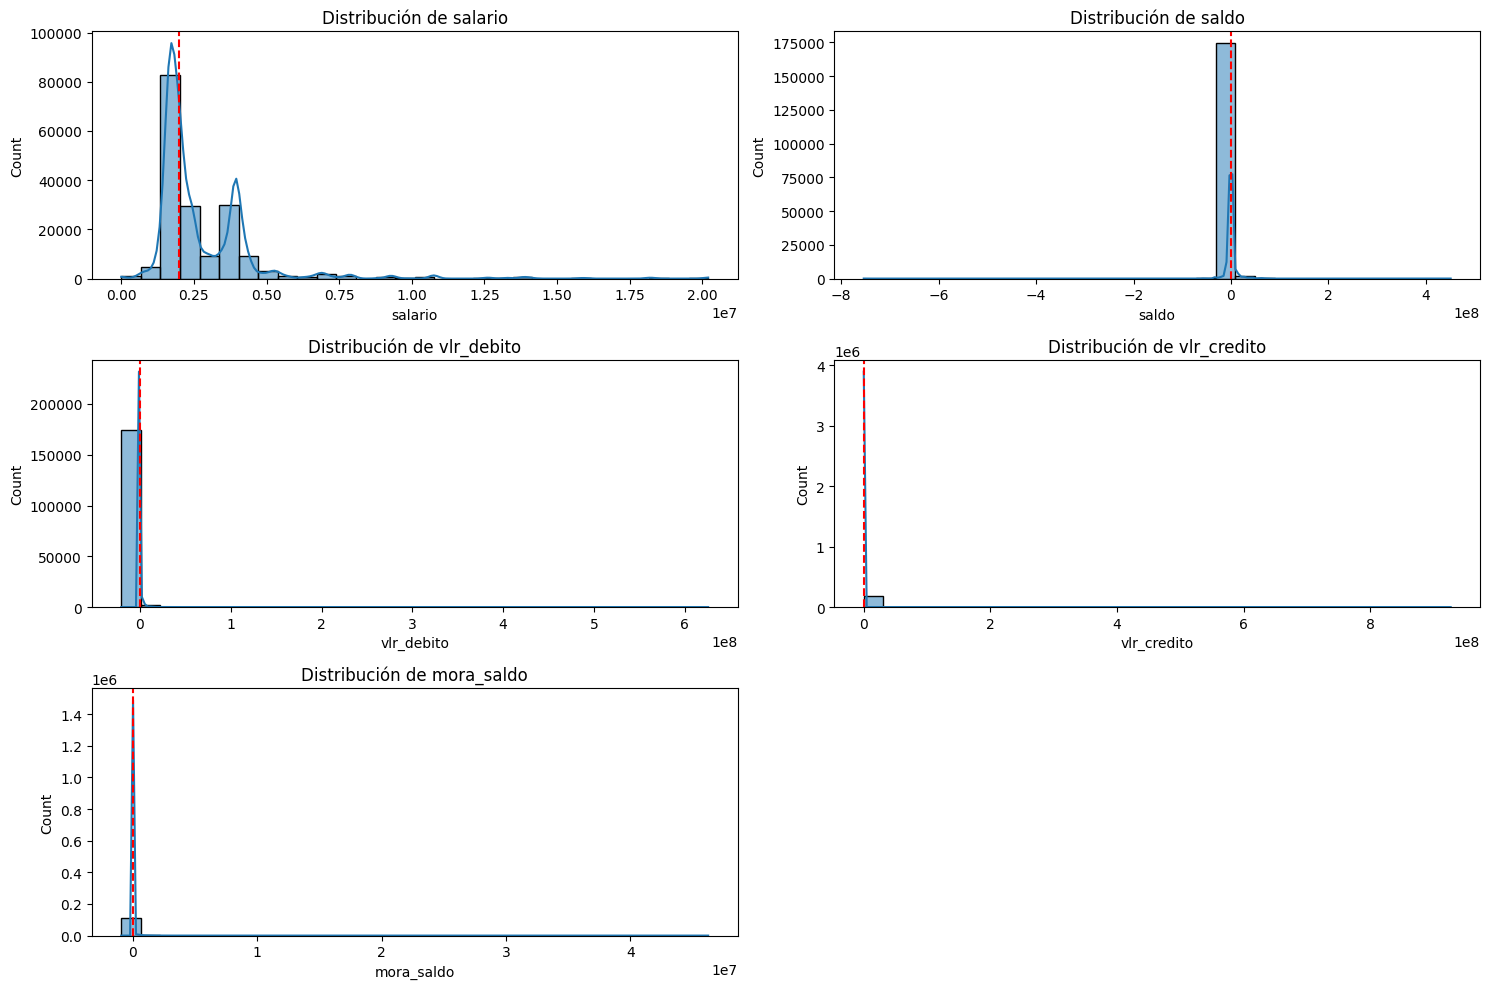

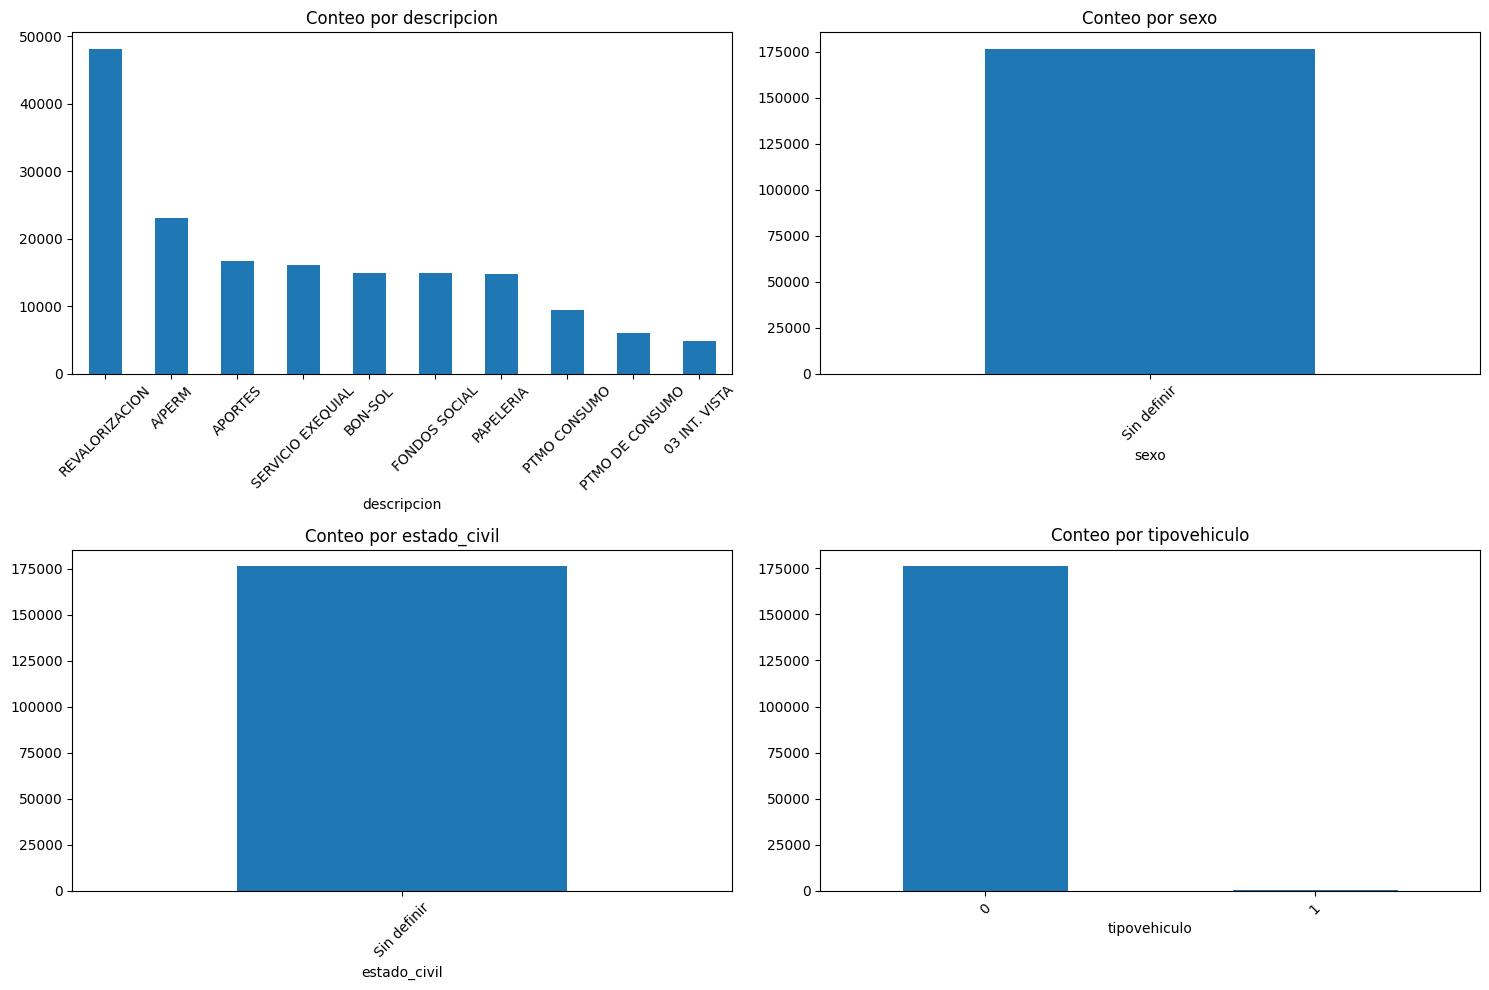


4. Análisis Bivariado


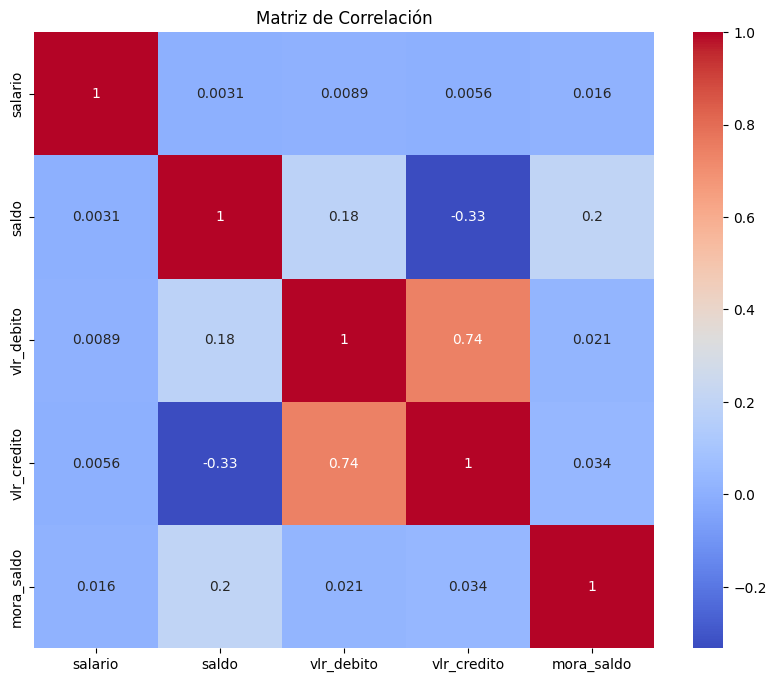

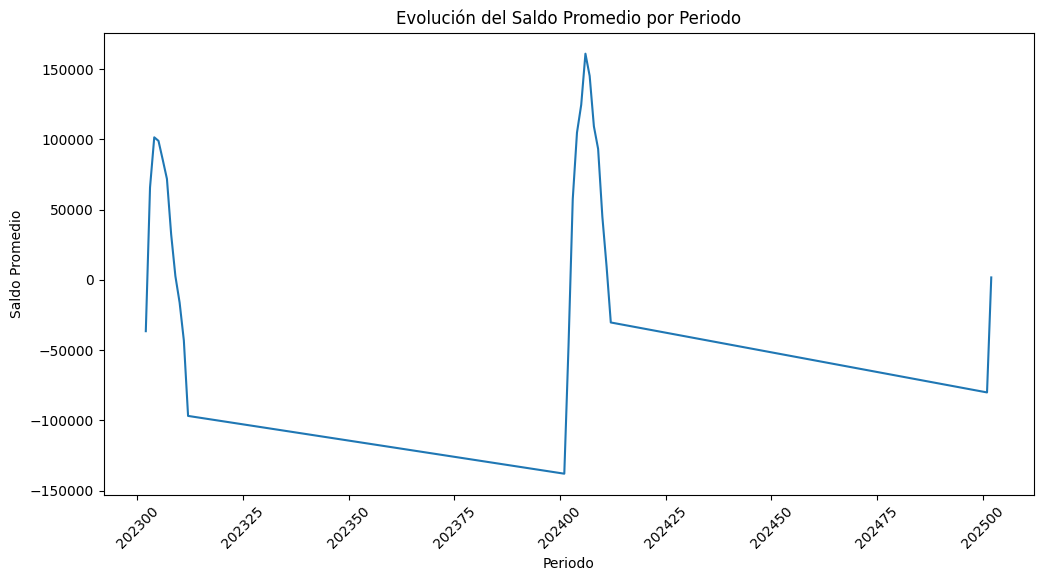


5. Análisis Multivariado


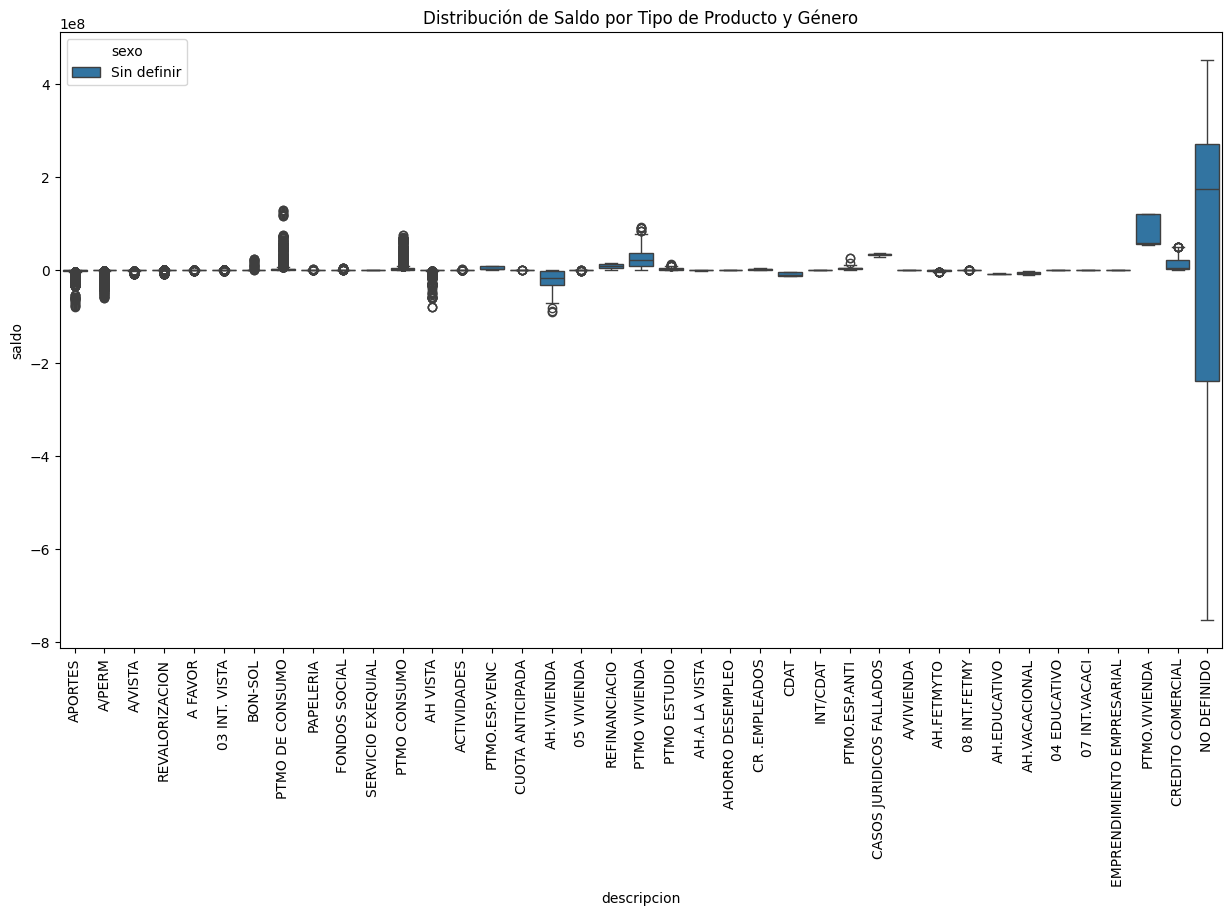


6. Detección de Anomalías


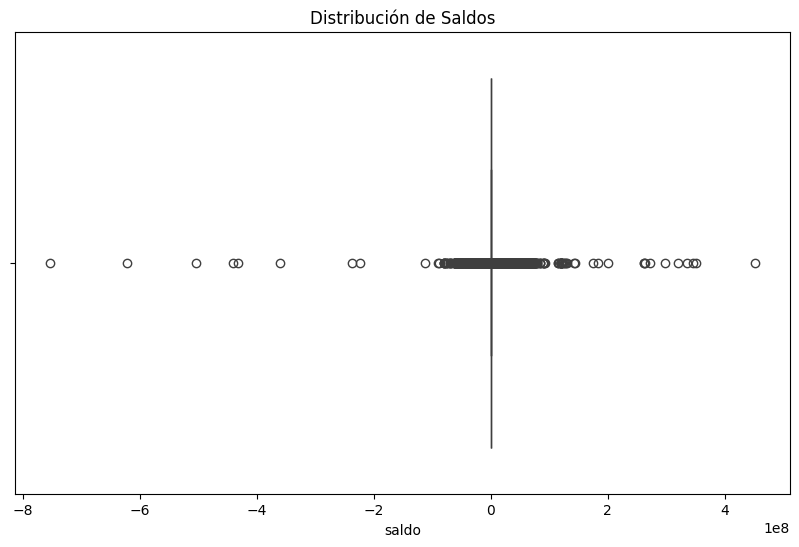


Top 5 transacciones con mayor saldo negativo:


,documento_identidad,descripcion,saldo
176624,99999999996618,NO DEFINIDO,-753825729.0
176612,99999999996618,NO DEFINIDO,-621581158.0
176600,99999999996618,NO DEFINIDO,-504560490.0
176623,99999999996618,NO DEFINIDO,-441764522.0
176611,99999999996618,NO DEFINIDO,-431869614.0



7. Análisis Temporal


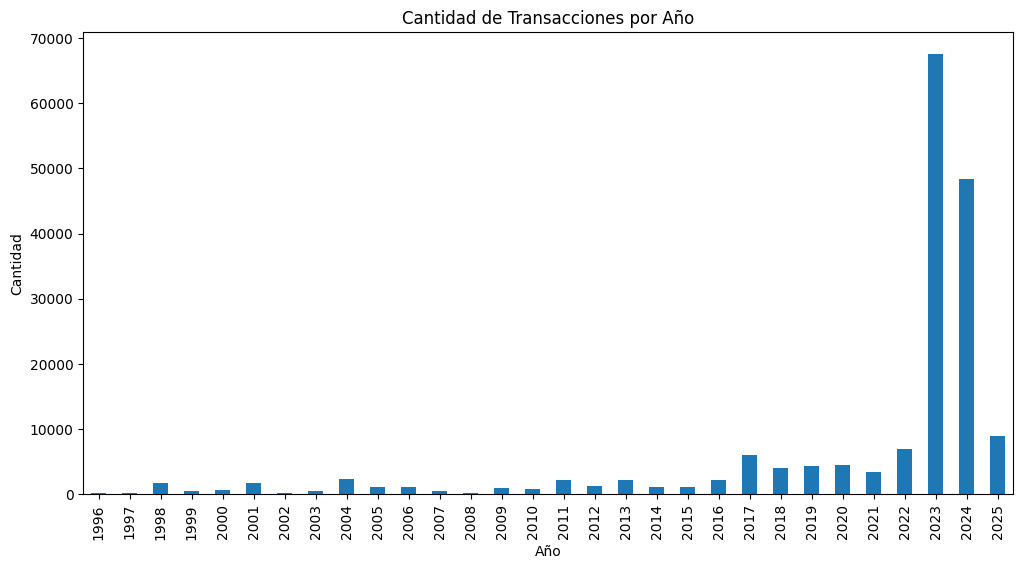


8. Resumen de Hallazgos
Principales hallazgos:
    1. Distribución de salarios: [ 2600000.  1900000.  2131432.  2284958.  1500000.  1677500.  2300000.
  4349959.  2798925.  1525000.  1844500.  1700000.  1980000.  2420000.
  1705000.  4251098.  4536000. 14092980.  4183334.  1800000.   774000.
  3728586.        0.  8816292.  8876282.  3041702.  3927000.  2106923.
  2200000.  4422207.  1272000.  1687513.  4001802.  1754000.  2000000.
  1626000.  1660000.  2100000.  2485856.  1863000.  3411360.  4255032.
  3762057.  4366892.  1450000.  1896063.  5964760.  3512000.  5203000.
  1522000.  1200000.  1680000.  6796805.  1740000.  1421000.  3800000.
  6628800.  4900000.   689454.  4284000.  1765732.  2615134.  3510324.
  3919989.  4154730.  1870000.  2566333.  3100000.  2769975.  2591073.
  1547700.  2856976.  2361517.  2722178.  1400000.  1300000.  1442000.
  3218000.  2077097.  2530000.  1482600.  2938344.  5743264.  1259775.
  1708670.  2666595.  1704000.   853426.  2094812. 10751862.  37803

In [17]:
# Ejecutar el EDA
perform_eda(db_staging_df)

***Hasta aqui segunda fase con la transformacion de la informacion***